In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from hankel import HankelTransform
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
import seaborn as sns
sns.set_style("ticks")

First computing: 

$$ \tilde{S}(k_{T}) = \int d²r e^{ik \cdot r} [1 - N(r)] = 2 \pi \int dr r J_0(k*r) (1 - N(r))$$

1. Compute for the peak positions of the parameters (truth)
2. Sample 100 parameters from posterior 
3. Compute and plot the average (median) and 1 standard dev (uncertainty estimate)

Question: is N(r) in initial condition given by

$$  N(r_T) = 1 - exp [ - \frac{r_T^2 Q_{s0}^2}{4}  ln ( \frac{1}{r_T \Lambda_{QCD}} + e_c \cdot e) ] $$

if so where does C² come into play?

When S(k) is obtained we are then able to get the leading order protom - nucleus cross sections in the hybrid formalism

$$ \frac{dN(b_T)}{dy d²k_T} = \frac{1}{(2\pi²)} xg(x, k_T²) \tilde{S}^A (k_T) $$ 

where $S^A(k_T)$ is obtained from

$$ N^A(r_T, b_T) = 1 - exp [ - A T_A(b_T) \frac{\sigma_0}{2} \frac{r_T^2 Q_{s0}^2}{4}  ln ( \frac{1}{r_T \Lambda_{QCD}} + e_c \cdot e) ]  $$

where $T_A$ is the Woods-Saxon nuclear density. Because the fully impact parameter dependent BK equation develops unphysical Coulomb tails, the scattering amplitudes are solved for each b_T independently. Not reliable in region $b_T \geq 6.3 fm$. The wood saxon nuclear density is the transverse thickness function of the nucleus obtained by integrating the Woods-Saxon distribution

$$ \rho_A(b_T, z) = \frac{n}{1 + exp [\frac{\sqrt{b_T^2 + z^2} + R_A}{d}]} $$

given d = 0.54 fm and $R_A = (1.12 A^{1/3} - 0.86 A^{-1/3})$ fm.


In [11]:
# define initial parameters of hankel transformation

ht = HankelTransform(nu = 0, # order of Bessel function
                     N = 1000, # Number of steps in integration
                     h = 0.001 # Proxy for size of steps
                     ) 

# define the function to transform

def dipp(r, Qs02, e_c): # dipole proton
    lambda_qcd = 0.241 #GeV
    B = (r**2)*(Qs02)
    C = (1/(r*lambda_qcd) + e_c * np.exp(1))
    N = 1 - np.exp(-B/4 * np.log(C))
    return N

def rho(z, bt, n): # Woods-Saxon distribution
    RA = 1.12*A**(1/3) - 0.86*A**(-1/3) # fm
    d = 0.54 # fm 
    # 5.068 fm = 1 GeV^-1 
    rhoA = n / (1 + np.exp((np.sqrt(bt**2 + z**2) + RA)/d))
    return rhoA

def woods_saxon(bt, n): # Woods-Saxon distribution T_A, integrated over z
    TA = integrate.quad(rho, -np.inf(), np.inf(), args = (bt, n))
    return TA[0]

def woods_saxon_4norm(bt, n): # just the previous function but times 2 pi bt
    TA = integrate.quad(rho, 0.0, 1.0, args = (bt, n))
    return 2 * np.pi * bt * TA[0]

def woods_saxon_norm(): # getting normalization constant
    a = 1
    ta_norm = integrate.quad(woods_saxon_4norm, 0.0, 10.0, args=(a))
    n = 1  / ta_norm[0]    
    return n

def dipA(r, A): # dipole nucleus
    lambda_qcd = 0.241 #GeV
    bt = 0.5 
    n = woods_saxon_norm()
    TA = woods_saxon(bt, n) 
    B = A * TA * (sigma0_2)*(r**2)*(Qs02)
    C = 1/(r*lambda_qcd) + e_c * np.exp(1)
    N = 1 - np.exp(-B/4 * np.log(C))
    return N

posterior_params_100 = np.vstack(np.loadtxt("mve/plainLHS/mve_100d_100w_sampled_from_posterior.txt", unpack = True)).T
posterior_params = np.vstack(np.loadtxt("mve/plainLHS/mve_100d_100w_allsamples.txt", unpack = True)).T
posterior_medians = np.median(posterior_params, axis = 0)
MAP = np.array([ 0.07696357,  7.46144896,  5.00327994, 15.02871265])
Qs02s = posterior_params[:,0]
e_cs = posterior_params[:,1]
sigma02 = posterior_params[:,-1]
func2 = lambda r: 1 - dipA(r, A)
k = np.logspace(-1,1,50)   

In [12]:
# sps = []
# for i in range(len(Qs02s)):
#     sp = ht.transform(lambda r: 1 - dipp(r, Qs02s[i], e_cs[i]), k, ret_err = False)
#     sps.append(sp)
#     plt.plot(k, sps[i], color = 'orange', alpha = 0.5)
#     if i == 0:
#         plt.plot(k, sp, color = 'orange', alpha = 0.5, label = 'Posterior samples')
#     if i % 10 == 0:
#         print(i)}

#sp_allk_median = []
#sp_allk_mean = []
# sp_allk_5 = []
# sp_allk_95 = []
# sp_all = []
# for i in k:
#     print(i)
#     sp_perk = [ht.transform(lambda r: 1 - dipp(r, Qs02s[j], e_cs[j]), i, ret_err = False) for j in range(len(Qs02s))]
#     sp_all.append(sp_perk)
#     #sp_allk_median.append(np.median(sp_perk))
#     sp_allk_5.append(np.percentile(sp_perk, 5))
#     sp_allk_95.append(np.percentile(sp_perk, 95))
#     #sp_allk_median.append(np.median(sp_perk))

# get 2 sigma uncertainty using nump

sp_median = ht.transform(lambda r: 1 - dipp(r, posterior_medians[0], posterior_medians[1]), k, ret_err = False)

In [13]:
sp_all = []
sp_sd = []
sigmats_all = []
sigmats_sd = []
sigmats_sd_median = []

for i in k:
    print(i)
    sp_perk = [ht.transform(lambda r: 1 - dipp(r, Qs02s[j], e_cs[j]), i, ret_err = False) for j in range(len(Qs02s))]
    sigmats = [sigma02[j] * sp_perk[j] for j in range(len(Qs02s))]
    sp_all.append(sp_perk)
    sp_sd.append(np.std(sp_perk))
    sigmats_all.append(sigmats)
    sigmats_sd.append(np.std(sigmats))
    sigmats_sd_median.append(np.median(sigmats))




0.1
0.10985411419875583
0.12067926406393285
0.13257113655901093
0.14563484775012436
0.15998587196060582
0.1757510624854792
0.193069772888325
0.21209508879201905
0.2329951810515372
0.2559547922699536
0.281176869797423
0.3088843596477481
0.3393221771895328
0.372759372031494
0.4094915062380424
0.44984326689694454
0.49417133613238345
0.5428675439323859
0.5963623316594643
0.6551285568595507
0.7196856730011519
0.7906043210907697
0.8685113737513525
0.9540954763499939
1.0481131341546859
1.151395399326447
1.2648552168552958
1.3894954943731375
1.5264179671752334
1.6768329368110073
1.8420699693267153
2.0235896477251565
2.2229964825261943
2.442053094548651
2.6826957952797246
2.9470517025518097
3.2374575428176433
3.5564803062231287
3.9069399370546147
4.291934260128776
4.714866363457392
5.17947467923121
5.689866029018296
6.25055192527397
6.866488450042998
7.543120063354615
8.286427728546842
9.102981779915218
10.0


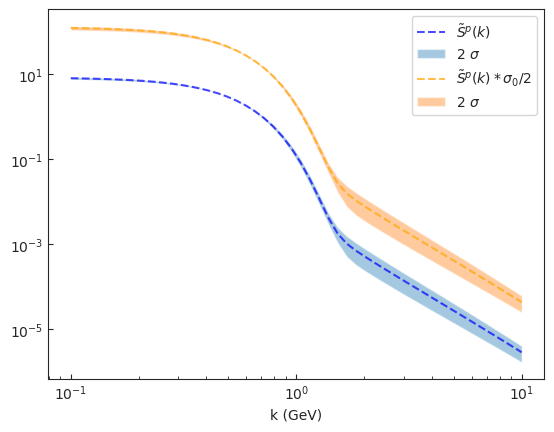

In [33]:
#plt.plot(k, sp_allk_median, label = 'Median Curve', color = 'black', alpha = 0.8)
#plt.plot(k, sp_allk_mean, '--', label = 'Mean Curve', color = 'red', alpha = 0.8)
u2 = sigmats_sd_median + 2*np.array(sigmats_sd)
d2 = sigmats_sd_median - 2*np.array(sigmats_sd)

u = sp_median + 2*np.array(sp_sd)
d = sp_median - 2*np.array(sp_sd)
plt.plot(k, sp_median, '--', alpha = 0.7, color = "blue", label = r'$\tilde{S}^p(k)$')
plt.fill_between(k, u, d, alpha = 0.4, label = "2 $\sigma$")

plt.plot(k, sigmats_sd_median, '--', alpha = 0.7, color = "orange", label = r'$\tilde{S}^p(k) * \sigma_0/2$')
plt.fill_between(k, u2, d2, alpha = 0.4, label = "2 $\sigma$")
plt.xscale('log')
plt.yscale('log')
#plt.ylabel(r'$\tilde{S}^p(k)$')
plt.xlabel('k (GeV)')
plt.tick_params(direction='in', which = 'both')
plt.legend()

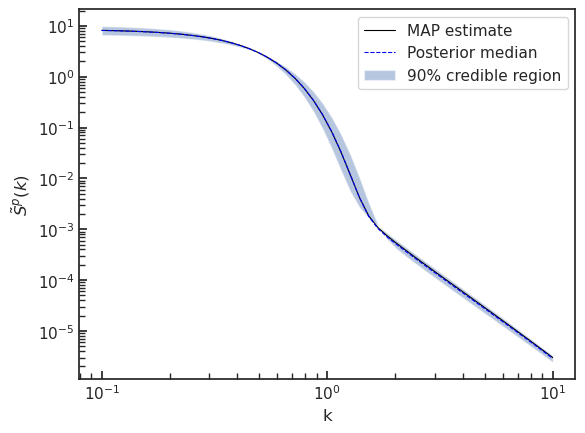

In [ ]:
sp_map = ht.transform(lambda r: 1 - dipp(r, MAP[0], MAP[1]), k, ret_err = False)
sp_median_5 = ht.transform(lambda r: 1 - dipp(r, percentile_5[0], percentile_5[1]), k, ret_err = False)
sp_median_95 = ht.transform(lambda r: 1 - dipp(r, percentile_95[0], percentile_95[1]), k, ret_err = False)
plt.plot(k, sp_map, linewidth = 0.8, color = "black", label = "MAP estimate")
plt.plot(k, sp_median, '--', linewidth = 0.8, color = "blue", label = "Posterior median")
plt.fill_between(k, sp_median_5, sp_median_95, alpha = 0.4, label = "90% credible region")

plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\tilde{S}^p(k)$')
plt.xlabel('k')
plt.tick_params(direction='in', which = 'both')
plt.legend()

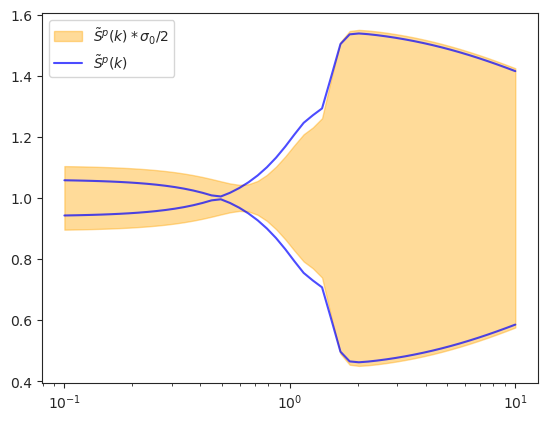

In [32]:
u2_norm = (sigmats_sd_median + 2*np.array(sigmats_sd))/sigmats_sd_median
d2_norm = (sigmats_sd_median - 2*np.array(sigmats_sd))/sigmats_sd_median

u_norm = (sp_median + 2*np.array(sp_sd))/sp_median
d_norm = (sp_median - 2*np.array(sp_sd))/sp_median

plt.fill_between(k, u2_norm, d2_norm, alpha = 0.4, color = 'orange', label = r'$\tilde{S}^p(k) * \sigma_0/2$')
# plt.fill_between(k, u_norm, d_norm, alpha = 0.4, label = r'$\tilde{S}^p(k)$')
plt.plot(k,u_norm, color = 'blue', alpha = 0.7, label = r'$\tilde{S}^p(k)$')
plt.plot(k,d_norm, color = 'blue', alpha = 0.7)
plt.legend()
plt.xscale('log')


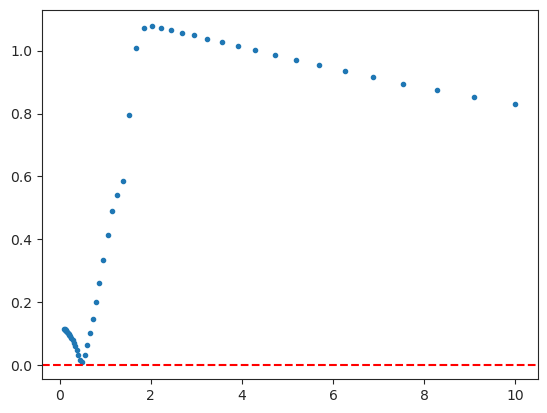

In [37]:
diff = u_norm - d_norm
plt.plot(k, diff, '.')
plt.axhline(y=0, color='r', linestyle='--')